In [2]:
import os, yaml
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from tqdm import tqdm
from utils.dataset import CrystalDataset, CrystalDataLoader
from models.dgm import DGModel
import warnings

warnings.filterwarnings('ignore')

In [3]:
def return_layers(model):
    layer_list = []
    for name, param in model.named_parameters():
        if 'pred_head' in name:
            print(name, param.requires_grad)
            layer_list.append(name)
    return layer_list

In [4]:
def pred_fn(data_loader, model, datawrapper, device, criterion):
    mean, std = datawrapper.mean, datawrapper.std

    model.eval()  # Put model in evaluation mode.
    test_losses = []
    predictions = []
    labels = []

    print('Testing...')
    with torch.no_grad():  # Disable gradient calculation.
        for batch_step, (se3_graph_prompt, so3_graph_prompt, y) in tqdm(enumerate(data_loader), total=len(data_loader)):  # Loop over all batches.
            # optimizer.zero_grad()  # To zero out the gradients.

            se3_graph_prompt, so3_graph_prompt, y = se3_graph_prompt.to(device), so3_graph_prompt.to(device), y.to(device)
            
            y_pred = model(se3_graph_prompt, so3_graph_prompt)
            
            loss = criterion(y_pred, y)
            test_losses.append(loss.item())

            if device == 'cpu':
                predictions.extend(y_pred.detach().numpy())
                labels.extend(y.detach().numpy())

            else:
                predictions.extend(y_pred.cpu().detach().numpy())
                labels.extend(y.cpu().flatten().numpy())

    # predictions = np.array(predictions)
    # labels.append(labels)
    labels = (np.array(labels) * std) + mean
    predictions = (np.array(predictions) * std) + mean
    
    # MAE, R2-score, RMSE
    (mae, r2, rmse) = (
        mean_absolute_error(labels, predictions),
        r2_score(labels, predictions),
        mean_squared_error(labels, predictions, squared=False)
    )
    
    # print('Test loss:', np.mean(test_losses), 'Test MAE:', mae)

    return np.mean(test_losses), mae, r2, rmse, predictions, labels

In [5]:
def save_embeds(pickle_path, se3_graph_embed, so3_graph_embed, expert_embeddings,
                predictions, labels):
    import pickle
    # df = np.array(features, dtype=np.float32)

    df = pd.DataFrame({
        'predictions': predictions,
        'labels': labels,
        'se3_graph_embed': se3_graph_embed,
        'so3_graph_embed': so3_graph_embed,
        'expert_embeddings': expert_embeddings})

    with open(pickle_path, 'wb') as f:
        # pickle.dump
        pickle.dump(df, f)

In [6]:
# MSE loss
criterion = nn.MSELoss(reduce='mean')

In [7]:
# file =  open('mae.txt', 'a')
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ['CUDA_LAUNCH_BLOCKING'] = '0'

config = yaml.load(open("/home/zl/DGM/config/finetune.yml", "r"), Loader=yaml.FullLoader)
config['device'] = 'cuda:0'
print(config)

{'root': '/home/zl/DGM/dataset/finetune/processed', 'name': 'megnet_processed.pt', 'target': 'e_form', 'task': 'finetune', 'train_size': 60000, 'val_size': 5000, 'test_size': 4239, 'random_seed': 123, 'idx_save_file': '_ids_train_val_test_', 'epochs': 500, 'batch_size': 8, 'num_workers': 0, 'weight_decay': 0.0, 'learning_rate': 0.0005, 'warmup_steps': 10, 'device': 'cuda:0', 'normalize': True, 'pretrained_model_pt': 'pretraining_checkpoint_best.pt', 'load_pretrained_model_path': '/home/zl/DGM/ckpt/pretraining', 'resume_ckpt_path': '/home/zl/DGM/ckpt/finetuned', 'ckpt_save_path': '/home/zl/DGM/ckpt/finetuned', 'model': {'conv_layers': 3, 'rbf_min': -4.0, 'rbf_max': 4.0, 'atom_input_features': 92, 'inf_edge_features': 64, 'fc_features': 256, 'graph_embed_dim': 256, 'euclidean': False, 'transformer': True, 'projection_dim': 256, 'ns': 64, 'nv': 8, 'eno3': True, 'num_heads': 1, 'num_experts': 2, 'hidden_dim': 128, 'temperature': 0.1, 'lambda_': [1, 0.5, 0.5], 'use_cosine_similarity': True,

### e_form (Materials Project dataset)

In [8]:
config['batch_size'] = 16
model = DGModel(config=config,
                  config_model=config['model']).to(config['device'])

number of parameters: 12.24M


In [9]:
name = 'megnet_processed.pt'
target = 'e_form'

datawrapper = CrystalDataLoader(
root = config['root'],
name = name,
target = target,
batch_size = config['batch_size'],
num_workers = config['num_workers'],
train_size = 60000,
valid_size = 5000,
test_size = 4239,
normalize = config['normalize'],
idx_save_file = config['idx_save_file'],
random_seed = config['random_seed']
)

_, _, test_loader = datawrapper.get_data_loaders()
print(test_loader)

Load from saved e_form train_val_test idx !!!
Normalized e_form !!!


In [10]:
save_checkpoint = 'e_form_checkpoint_best.pt'

if config['ckpt_save_path']:
    # print('Loading pre-trained model from', config['load_pretrained_model_path'])
    ckpt_save_path = str(os.path.join(config['ckpt_save_path'], target))

    try:
        state_dict = torch.load(os.path.join(ckpt_save_path, str(save_checkpoint)),
                                map_location=config['device'])

        model.load_state_dict(state_dict, strict=True)
        print('Loading saved finetuned-model from', config['ckpt_save_path'], 'with success.')

    except FileNotFoundError:
        print("Saved finetuned-model weights not found. Predict from scratch.")

Loading saved finetuned-model from /home/zl/DGM/ckpt/finetuned with success.


In [34]:
(test_loss, test_MAE, test_R2_score, 
 test_RMSE, predictions, labels) = (
    pred_fn(test_loader, model, datawrapper, config['device'], criterion))

print('test loss is:', round(test_loss, 5))
print('test MAE is:', round(test_MAE, 5))
print('test R2_score is:', round(test_R2_score, 5))
print('test RMSE is:', round(test_RMSE, 5))

Testing...


100%|██████████| 264/264 [00:10<00:00, 24.23it/s]

test loss is: 0.0005
test MAE is: 0.01653
test R2_score is: 0.99948
test RMSE is: 0.02403


Text(0.5, 1.0, 'Formation Energy MAE = 0.01653')

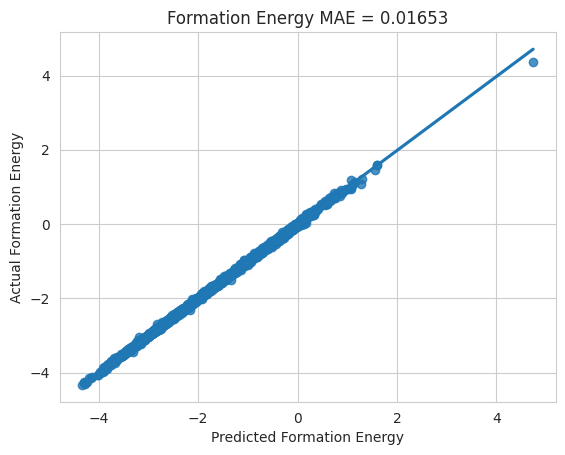

In [35]:
sns.regplot(x=predictions, y=labels)
plt.xlabel('Predicted Formation Energy')
plt.ylabel('Actual Formation Energy')
plt.title(f'Formation Energy MAE = {test_MAE:.5f}')

### gap pbe (Materials Project dataset)

In [11]:
config['batch_size'] = 16
model = DGModel(config=config,
                  config_model=config['model']).to(config['device'])

number of parameters: 12.24M


In [12]:
name = 'megnet_processed.pt'
target = 'gap pbe'

datawrapper = CrystalDataLoader(
    root = config['root'],
    name = name,
    target = target,
    batch_size = config['batch_size'],
    num_workers = config['num_workers'],
    train_size = 60000,
    valid_size = 5000,
    test_size = 4239,
    normalize = config['normalize'],
    idx_save_file = config['idx_save_file'],
    random_seed = config['random_seed']
)

_, _, test_loader = datawrapper.get_data_loaders()
print(test_loader)

Load from saved gap pbe train_val_test idx !!!
Normalized gap pbe !!!


In [13]:
save_checkpoint = 'gap pbe_checkpoint_best.pt'

if config['ckpt_save_path']:
    # print('Loading pre-trained model from', config['load_pretrained_model_path'])
    ckpt_save_path = str(os.path.join(config['ckpt_save_path'], target))

    try:
        state_dict = torch.load(os.path.join(ckpt_save_path, str(save_checkpoint)),
                                map_location=config['device'])

        model.load_state_dict(state_dict, strict=True)
        print('Loading saved finetuned-model from', config['ckpt_save_path'], 'with success.')

    except FileNotFoundError:
        print("Saved finetuned-model weights not found. Predict from scratch.")

Loading saved finetuned-model from /home/zl/DGM/ckpt/finetuned with success.


In [33]:
(test_loss, test_MAE, test_R2_score, 
 test_RMSE, predictions, labels) = (
    pred_fn(test_loader, model, datawrapper, config['device'], criterion))

print('test loss is:', round(test_loss, 5))
print('test MAE is:', round(test_MAE, 5))
print('test R2_score is:', round(test_R2_score, 5))
print('test RMSE is:', round(test_RMSE, 5))

Testing...


100%|██████████| 264/264 [00:10<00:00, 25.22it/s]

test loss is: 0.03391
test MAE is: 0.18497
test R2_score is: 0.96486
test RMSE is: 0.29912


Text(0.5, 1.0, 'Band Gap MAE = 0.18497')

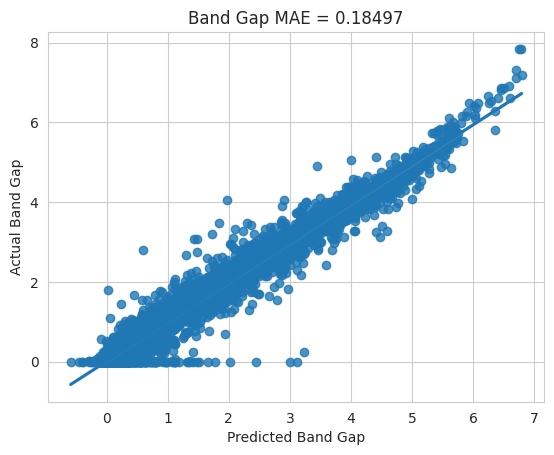

In [34]:
sns.regplot(x=predictions, y=labels)
plt.xlabel('Predicted Band Gap')
plt.ylabel('Actual Band Gap')
plt.title(f'Band Gap MAE = {test_MAE:.5f}')

### bulk modulus (Materials Project dataset)

In [14]:
config['batch_size'] = 16
model = DGModel(config=config,
                  config_model=config['model']).to(config['device'])

number of parameters: 12.24M


In [15]:
name = 'bulk_moduli_processed.pt'
target = 'bulk modulus'

datawrapper = CrystalDataLoader(
    root = config['root'],
    name = name,
    target = target,
    batch_size = config['batch_size'],
    num_workers = config['num_workers'],
    train_size = 4664,
    valid_size = 393,
    test_size = 393,
    normalize = config['normalize'],
    idx_save_file = config['idx_save_file'],
    random_seed = config['random_seed']
)

_, _, test_loader = datawrapper.get_data_loaders()
print(test_loader)

Load from saved bulk modulus train_val_test idx !!!
Not normalized with bulk modulus !!!


In [16]:
save_checkpoint = 'bulk modulus_checkpoint_best.pt'

if config['ckpt_save_path']:
    # print('Loading pre-trained model from', config['load_pretrained_model_path'])
    ckpt_save_path = str(os.path.join(config['ckpt_save_path'], target))

    try:
        state_dict = torch.load(os.path.join(ckpt_save_path, str(save_checkpoint)),
                                map_location=config['device'])

        model.load_state_dict(state_dict, strict=True)
        print('Loading saved finetuned-model from', config['ckpt_save_path'], 'with success.')

    except FileNotFoundError:
        print("Saved finetuned-model weights not found. Predict from scratch.")

Loading saved finetuned-model from /home/zl/DGM/ckpt/finetuned with success.


In [12]:
(test_loss, test_MAE, test_R2_score, 
 test_RMSE, predictions, labels) = (
    pred_fn(test_loader, model, datawrapper, config['device'], criterion))

print('test loss is:', round(test_loss, 5))
print('test MAE is:', round(test_MAE, 5))
print('test R2_score is:', round(test_R2_score, 5))
print('test RMSE is:', round(test_RMSE, 5))

Testing...


100%|██████████| 24/24 [00:00<00:00, 60.03it/s]

test loss is: 0.00268
test MAE is: 0.02972
test R2_score is: 0.97974
test RMSE is: 0.05181


Text(0.5, 1.0, 'Bulk Moduli MAE = 0.02972')

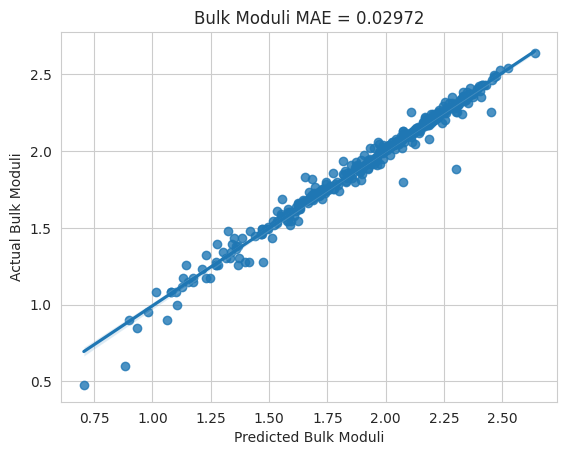

In [13]:
sns.regplot(x=predictions, y=labels)
plt.xlabel('Predicted Bulk Moduli')
plt.ylabel('Actual Bulk Moduli')
plt.title(f'Bulk Moduli MAE = {test_MAE:.5f}')

### shear modulus (Materials Project dataset)

In [17]:
config['batch_size'] = 16
model = DGModel(config=config,
                  config_model=config['model']).to(config['device'])

number of parameters: 12.24M


In [18]:
name = 'shear_moduli_processed.pt'
target = 'shear modulus'

datawrapper = CrystalDataLoader(
    root = config['root'],
    name = name,
    target = target,
    batch_size = config['batch_size'],
    num_workers = config['num_workers'],
    train_size = 4664,
    valid_size = 392,
    test_size = 393,
    normalize = config['normalize'],
    idx_save_file = config['idx_save_file'],
    random_seed = config['random_seed']
)

_, _, test_loader = datawrapper.get_data_loaders()
print(test_loader)

Load from saved shear modulus train_val_test idx !!!
Not normalized with shear modulus !!!


In [19]:
save_checkpoint = 'shear modulus_checkpoint_best.pt'

if config['ckpt_save_path']:
    # print('Loading pre-trained model from', config['load_pretrained_model_path'])
    ckpt_save_path = str(os.path.join(config['ckpt_save_path'], target))

    try:
        state_dict = torch.load(os.path.join(ckpt_save_path, str(save_checkpoint)),
                                map_location=config['device'])

        model.load_state_dict(state_dict, strict=True)
        print('Loading saved finetuned-model from', config['ckpt_save_path'], 'with success.')

    except FileNotFoundError:
        print("Saved finetuned-model weights not found. Predict from scratch.")

Loading saved finetuned-model from /home/zl/DGM/ckpt/finetuned with success.


In [26]:
(test_loss, test_MAE, test_R2_score, 
 test_RMSE, predictions, labels) = (
    pred_fn(test_loader, model, datawrapper, config['device'], criterion))

print('test loss is:', round(test_loss, 5))
print('test MAE is:', round(test_MAE, 5))
print('test R2_score is:', round(test_R2_score, 5))
print('test RMSE is:', round(test_RMSE, 5))

Testing...


100%|██████████| 24/24 [00:00<00:00, 37.26it/s]

test loss is: 0.00525
test MAE is: 0.0557
test R2_score is: 0.95831
test RMSE is: 0.07244


Text(0.5, 1.0, 'Shear Moduli MAE = 0.05570')

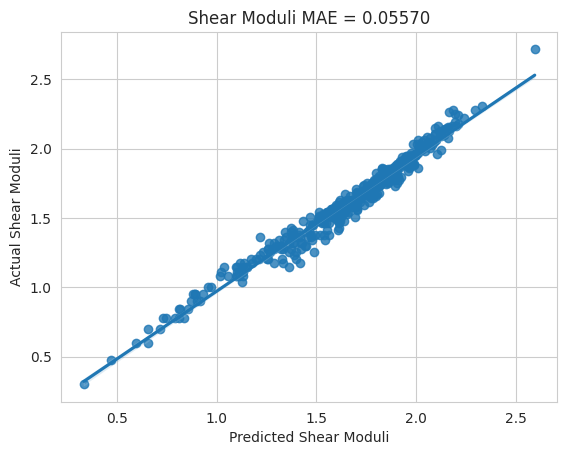

In [27]:
sns.regplot(x=predictions, y=labels)
plt.xlabel('Predicted Shear Moduli')
plt.ylabel('Actual Shear Moduli')
plt.title(f'Shear Moduli MAE = {test_MAE:.5f}')

### formation_energy_peratom (JARVIS dataset)

In [20]:
config['batch_size'] = 16
model = DGModel(config=config,
                  config_model=config['model']).to(config['device'])

number of parameters: 12.24M


In [21]:
name = 'dft_3d_processed.pt'
target = 'formation_energy_peratom'

datawrapper = CrystalDataLoader(
root = config['root'],
name = name,
target = target,
batch_size = config['batch_size'],
num_workers = config['num_workers'],
train_size = 44578,
valid_size = 5572,
test_size = 5572,
normalize = config['normalize'],
idx_save_file = config['idx_save_file'],
random_seed = config['random_seed']
)

_, _, test_loader = datawrapper.get_data_loaders()
print(test_loader)

Load from saved formation_energy_peratom train_val_test idx !!!
Normalized formation_energy_peratom !!!


In [22]:
save_checkpoint = 'formation_energy_peratom_checkpoint_best.pt'

if config['ckpt_save_path']:
    # print('Loading pre-trained model from', config['load_pretrained_model_path'])
    ckpt_save_path = str(os.path.join(config['ckpt_save_path'], target))

    try:
        state_dict = torch.load(os.path.join(ckpt_save_path, str(save_checkpoint)),
                                map_location=config['device'])

        model.load_state_dict(state_dict, strict=True)
        print('Loading saved finetuned-model from', config['ckpt_save_path'], 'with success.')

    except FileNotFoundError:
        print("Saved finetuned-model weights not found. Predict from scratch.")

Loading saved finetuned-model from /home/zl/DGM/ckpt/finetuned with success.


In [33]:
(test_loss, test_MAE, test_R2_score, 
 test_RMSE, predictions, labels) = (
    pred_fn(test_loader, model, datawrapper, config['device'], criterion))

print('test loss is:', round(test_loss, 5))
print('test MAE is:', round(test_MAE, 5))
print('test R2_score is:', round(test_R2_score, 5))
print('test RMSE is:', round(test_RMSE, 5))

Testing...


100%|██████████| 348/348 [00:06<00:00, 55.70it/s]

test loss is: 0.00111
test MAE is: 0.02608
test R2_score is: 0.99892
test RMSE is: 0.03597


Text(0.5, 1.0, 'Formation Energy MAE = 0.02608')

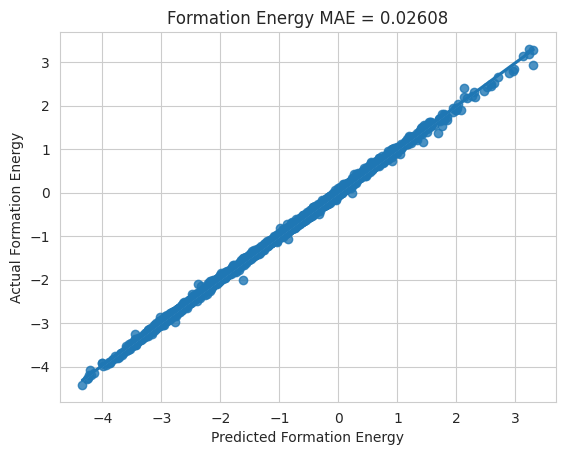

In [34]:
sns.regplot(x=predictions, y=labels)
plt.xlabel('Predicted Formation Energy')
plt.ylabel('Actual Formation Energy')
plt.title(f'Formation Energy MAE = {test_MAE:.5f}')

### optb88vdw_bandgap (JARVIS dataset)

In [23]:
config['batch_size'] = 16
model = DGModel(config=config,
                  config_model=config['model']).to(config['device'])

number of parameters: 12.24M


In [24]:
name = 'dft_3d_processed.pt'
target = 'optb88vdw_bandgap'

datawrapper = CrystalDataLoader(
    root = config['root'],
    name = name,
    target = target,
    batch_size = config['batch_size'],
    num_workers = config['num_workers'],
    train_size = 44578,
    valid_size = 5572,
    test_size = 5572,
    normalize = config['normalize'],
    idx_save_file = config['idx_save_file'],
    random_seed = config['random_seed']
)

_, _, test_loader = datawrapper.get_data_loaders()
print(test_loader)

Save optb88vdw_bandgap train_val_test idx !!!
Normalized optb88vdw_bandgap !!!


In [25]:
save_checkpoint = 'optb88vdw_bandgap_checkpoint_best.pt'

if config['ckpt_save_path']:
    # print('Loading pre-trained model from', config['load_pretrained_model_path'])
    ckpt_save_path = str(os.path.join(config['ckpt_save_path'], target))

    try:
        state_dict = torch.load(os.path.join(ckpt_save_path, str(save_checkpoint)),
                                map_location=config['device'])

        model.load_state_dict(state_dict, strict=True)
        print('Loading saved finetuned-model from', config['ckpt_save_path'], 'with success.')

    except FileNotFoundError:
        print("Saved finetuned-model weights not found. Predict from scratch.")

Loading saved finetuned-model from /home/zl/DGM/ckpt/finetuned with success.


In [22]:
(test_loss, test_MAE, test_R2_score, 
 test_RMSE, predictions, labels) = (
    pred_fn(test_loader, model, datawrapper, config['device'], criterion))

print('test loss is:', round(test_loss, 5))
print('test MAE is:', round(test_MAE, 5))
print('test R2_score is:', round(test_R2_score, 5))
print('test RMSE is:', round(test_RMSE, 5))

Testing...


100%|██████████| 348/348 [00:06<00:00, 57.22it/s]

test loss is: 0.02841
test MAE is: 0.11435
test R2_score is: 0.97228
test RMSE is: 0.2362


Text(0.5, 1.0, 'Bandgap (OPT) MAE = 0.11435')

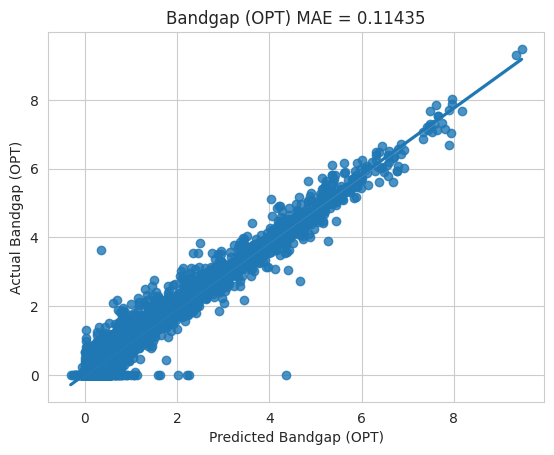

In [23]:
sns.regplot(x=predictions, y=labels)
plt.xlabel('Predicted Bandgap (OPT)')
plt.ylabel('Actual Bandgap (OPT)')
plt.title(f'Bandgap (OPT) MAE = {test_MAE:.5f}')

### optb88vdw_total_energy (JARVIS dataset)

In [26]:
config['batch_size'] = 16
model = DGModel(config=config,
                  config_model=config['model']).to(config['device'])

number of parameters: 12.24M


In [27]:
name = 'dft_3d_processed.pt'
target = 'optb88vdw_total_energy'

datawrapper = CrystalDataLoader(
root = config['root'],
name = name,
target = target,
batch_size = config['batch_size'],
num_workers = config['num_workers'],
train_size = 44578,
valid_size = 5572,
test_size = 5572,
normalize = config['normalize'],
idx_save_file = config['idx_save_file'],
random_seed = config['random_seed']
)

_, _, test_loader = datawrapper.get_data_loaders()
print(test_loader)

Save optb88vdw_total_energy train_val_test idx !!!
Normalized optb88vdw_total_energy !!!


In [28]:
save_checkpoint = 'optb88vdw_total_energy_checkpoint_best.pt'

if config['ckpt_save_path']:
    # print('Loading pre-trained model from', config['load_pretrained_model_path'])
    ckpt_save_path = str(os.path.join(config['ckpt_save_path'], target))

    try:
        state_dict = torch.load(os.path.join(ckpt_save_path, str(save_checkpoint)),
                                map_location=config['device'])

        model.load_state_dict(state_dict, strict=True)
        print('Loading saved finetuned-model from', config['ckpt_save_path'], 'with success.')

    except FileNotFoundError:
        print("Saved finetuned-model weights not found. Predict from scratch.")

Loading saved finetuned-model from /home/zl/DGM/ckpt/finetuned with success.


In [85]:
(test_loss, test_MAE, test_R2_score, 
 test_RMSE, predictions, labels) = (
    pred_fn(test_loader, model, datawrapper, config['device'], criterion))

print('test loss is:', round(test_loss, 5))
print('test MAE is:', round(test_MAE, 5))
print('test R2_score is:', round(test_R2_score, 5))
print('test RMSE is:', round(test_RMSE, 5))

Testing...


100%|██████████| 348/348 [00:06<00:00, 54.72it/s]

test loss is: 0.00029
test MAE is: 0.02726
test R2_score is: 0.99971
test RMSE is: 0.03634


Text(0.5, 1.0, 'Total energy MAE = 0.02726')

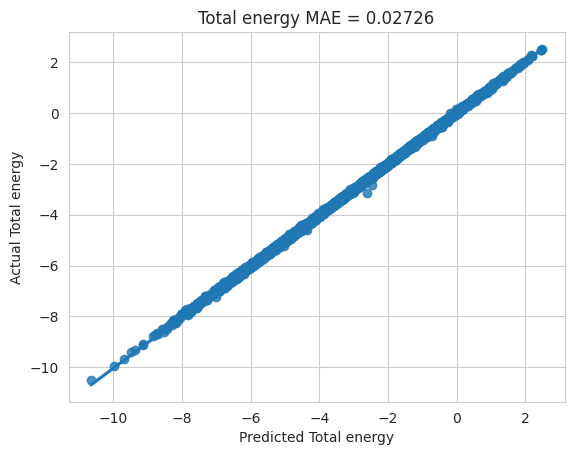

In [86]:
sns.regplot(x=predictions, y=labels)
plt.xlabel('Predicted Total energy')
plt.ylabel('Actual Total energy')
plt.title(f'Total energy MAE = {test_MAE:.5f}')

### mbj_bandgap (JARVIS dataset)

In [29]:
config['batch_size'] = 16
model = DGModel(config=config,
                  config_model=config['model']).to(config['device'])

number of parameters: 12.24M


In [30]:
name = 'dft_3d_processed.pt'
target = 'mbj_bandgap'

datawrapper = CrystalDataLoader(
    root = config['root'],
    name = name,
    target = target,
    batch_size = config['batch_size'],
    num_workers = config['num_workers'],
    train_size = 14537,
    valid_size = 1817,
    test_size = 1817,
    normalize = config['normalize'],
    idx_save_file = config['idx_save_file'],
    random_seed = config['random_seed']
)

_, _, test_loader = datawrapper.get_data_loaders()
print(test_loader)

Save mbj_bandgap train_val_test idx !!!
Normalized mbj_bandgap !!!


In [31]:
save_checkpoint = 'mbj_bandgap_checkpoint_best.pt'

if config['ckpt_save_path']:
    # print('Loading pre-trained model from', config['load_pretrained_model_path'])
    ckpt_save_path = str(os.path.join(config['ckpt_save_path'], target))

    try:
        state_dict = torch.load(os.path.join(ckpt_save_path, str(save_checkpoint)),
                                map_location=config['device'])

        model.load_state_dict(state_dict, strict=True)
        print('Loading saved finetuned-model from', config['ckpt_save_path'], 'with success.')

    except FileNotFoundError:
        print("Saved finetuned-model weights not found. Predict from scratch.") 

Loading saved finetuned-model from /home/zl/DGM/ckpt/finetuned with success.


In [28]:
(test_loss, test_MAE, test_R2_score, 
 test_RMSE, predictions, labels) = (
    pred_fn(test_loader, model, datawrapper, config['device'], criterion))

print('test loss is:', round(test_loss, 5))
print('test MAE is:', round(test_MAE, 5))
print('test R2_score is:', round(test_R2_score, 5))
print('test RMSE is:', round(test_RMSE, 5))

Testing...


100%|██████████| 113/113 [00:01<00:00, 59.43it/s]

test loss is: 0.02147
test MAE is: 0.18981
test R2_score is: 0.97999
test RMSE is: 0.33907


Text(0.5, 1.0, 'Bandgap (MBJ) MAE = 0.18981')

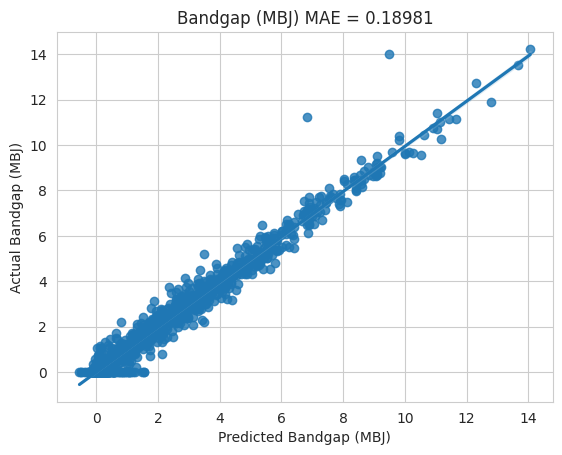

In [29]:
sns.regplot(x=predictions, y=labels)
plt.xlabel('Predicted Bandgap (MBJ)')
plt.ylabel('Actual Bandgap (MBJ)')
plt.title(f'Bandgap (MBJ) MAE = {test_MAE:.5f}')

### ehull (JARVIS dataset)

In [32]:
config['batch_size'] = 16
model = DGModel(config=config,
                  config_model=config['model']).to(config['device'])

number of parameters: 12.24M


In [33]:
name = 'dft_3d_processed.pt'
target = 'ehull'

datawrapper = CrystalDataLoader(
    root = config['root'],
    name = name,
    target = target,
    batch_size = config['batch_size'],
    num_workers = config['num_workers'],
    train_size = 44296,
    valid_size = 5537,
    test_size = 5537,
    normalize = config['normalize'],
    idx_save_file = config['idx_save_file'],
    random_seed = config['random_seed']
)

_, _, test_loader = datawrapper.get_data_loaders()
print(test_loader)

Save ehull train_val_test idx !!!
Normalized ehull !!!


In [34]:
save_checkpoint = 'ehull_checkpoint_best.pt'

if config['ckpt_save_path']:
    # print('Loading pre-trained model from', config['load_pretrained_model_path'])
    ckpt_save_path = str(os.path.join(config['ckpt_save_path'], target))

    try:
        state_dict = torch.load(os.path.join(ckpt_save_path, str(save_checkpoint)),
                                map_location=config['device'])

        model.load_state_dict(state_dict, strict=True)
        print('Loading saved finetuned-model from', config['ckpt_save_path'], 'with success.')

    except FileNotFoundError:
        print("Saved finetuned-model weights not found. Predict from scratch.")

Loading saved finetuned-model from /home/zl/DGM/ckpt/finetuned with success.


In [78]:
(test_loss, test_MAE, test_R2_score, 
 test_RMSE, predictions, labels) = (
    pred_fn(test_loader, model, datawrapper, config['device'], criterion))

print('test loss is:', round(test_loss, 5))
print('test MAE is:', round(test_MAE, 5))
print('test R2_score is:', round(test_R2_score, 5))
print('test RMSE is:', round(test_RMSE, 5))

Testing...


100%|██████████| 346/346 [00:06<00:00, 52.20it/s]

test loss is: 0.00141
test MAE is: 0.03752
test R2_score is: 0.99862
test RMSE is: 0.05217


Text(0.5, 1.0, 'Ehull MAE = 0.03752')

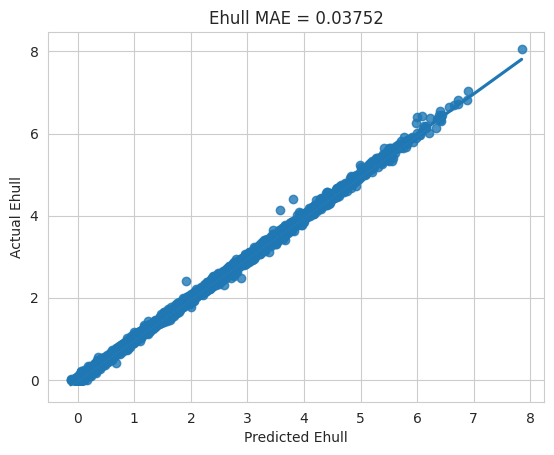

In [79]:
sns.regplot(x=predictions, y=labels)
plt.xlabel('Predicted Ehull')
plt.ylabel('Actual Ehull')
plt.title(f'Ehull MAE = {test_MAE:.5f}')

### alloy_gmae (Alloy GMAE dataset)

In [35]:
config['batch_size'] = 8
model = DGModel(config=config,
                  config_model=config['model']).to(config['device'])

number of parameters: 12.24M


In [36]:
name = 'alloy_gmae_processed.pt'
target = name.replace('_processed.pt', '')

datawrapper = CrystalDataLoader(
    root = config['root'],
    name = name,
    target = target,
    batch_size = config['batch_size'],
    num_workers = config['num_workers'],
    train_size = 0.8,
    valid_size = 0.1,
    test_size = 0.1,
    normalize = config['normalize'],
    idx_save_file = config['idx_save_file'],
    random_seed = config['random_seed']
)

_, _, test_loader = datawrapper.get_data_loaders()
print(test_loader)

Save alloy_gmae train_val_test idx !!!
Normalized alloy_gmae !!!


In [37]:
save_checkpoint = 'alloy_gmae_checkpoint_best.pt'

if config['ckpt_save_path']:
    # print('Loading pre-trained model from', config['load_pretrained_model_path'])
    ckpt_save_path = str(os.path.join(config['ckpt_save_path'], target))

    try:
        state_dict = torch.load(os.path.join(ckpt_save_path, str(save_checkpoint)),
                                map_location=config['device'])

        model.load_state_dict(state_dict, strict=True)
        print('Loading saved finetuned-model from', config['ckpt_save_path'], 'with success.')

    except FileNotFoundError:
        print("Saved finetuned-model weights not found. Predict from scratch.")

Loading saved finetuned-model from /home/zl/DGM/ckpt/finetuned with success.


In [37]:
(test_loss, test_MAE, test_R2_score, 
 test_RMSE, predictions, labels) = (
    pred_fn(test_loader, model, datawrapper, config['device'], criterion))

print('test loss is:', round(test_loss, 5))
print('test MAE is:', round(test_MAE, 5))
print('test R2_score is:', round(test_R2_score, 5))
print('test RMSE is:', round(test_RMSE, 5))

Testing...


100%|██████████| 140/140 [00:01<00:00, 76.79it/s]

test loss is: 0.00834
test MAE is: 0.07453
test R2_score is: 0.99126
test RMSE is: 0.16821


Text(0.5, 1.0, 'Alloy GMAE MAE = 0.07453')

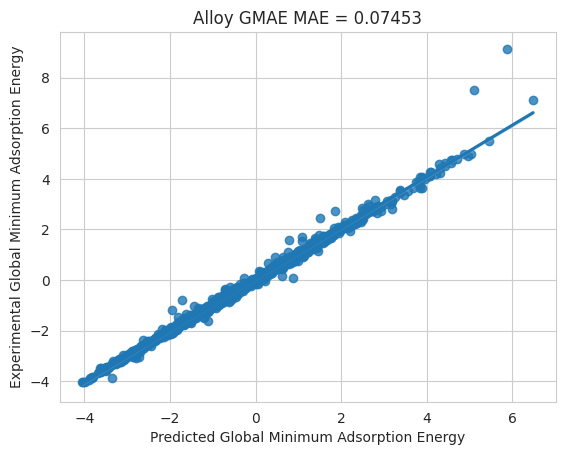

In [38]:
sns.regplot(x=predictions, y=labels)
plt.xlabel('Predicted Global Minimum Adsorption Energy')
plt.ylabel('Experimental Global Minimum Adsorption Energy')
plt.title(f'Alloy GMAE MAE = {test_MAE:.5f}')

### fg_gmae (FG GMAE dataset)

In [38]:
config['batch_size'] = 8
model = DGModel(config=config,
                  config_model=config['model']).to(config['device'])

number of parameters: 12.24M


In [39]:
name = 'fg_gmae_processed.pt'
target = name.replace('_processed.pt', '')

datawrapper = CrystalDataLoader(
    root = config['root'],
    name = name,
    target = target,
    batch_size = config['batch_size'],
    num_workers = config['num_workers'],
    train_size = 0.8,
    valid_size = 0.1,
    test_size = 0.1,
    normalize = config['normalize'],
    idx_save_file = config['idx_save_file'],
    random_seed = config['random_seed']
)

_, _, test_loader = datawrapper.get_data_loaders()
print(test_loader)

Save fg_gmae train_val_test idx !!!
Normalized fg_gmae !!!


In [40]:
save_checkpoint = 'fg_gmae_checkpoint_best.pt'

if config['ckpt_save_path']:
    # print('Loading pre-trained model from', config['load_pretrained_model_path'])
    ckpt_save_path = str(os.path.join(config['ckpt_save_path'], target))

    try:
        state_dict = torch.load(os.path.join(ckpt_save_path, str(save_checkpoint)),
                                map_location=config['device'])

        model.load_state_dict(state_dict, strict=True)
        print('Loading saved finetuned-model from', config['ckpt_save_path'], 'with success.')

    except FileNotFoundError:
        print("Saved finetuned-model weights not found. Predict from scratch.")

Loading saved finetuned-model from /home/zl/DGM/ckpt/finetuned with success.


In [43]:
(test_loss, test_MAE, test_R2_score, 
 test_RMSE, predictions, labels) = (
    pred_fn(test_loader, model, datawrapper, config['device'], criterion))

print('test loss is:', round(test_loss, 5))
print('test MAE is:', round(test_MAE, 5))
print('test R2_score is:', round(test_R2_score, 5))
print('test RMSE is:', round(test_RMSE, 5))

Testing...


100%|██████████| 37/37 [00:01<00:00, 22.42it/s]

test loss is: 0.0201
test MAE is: 0.0381
test R2_score is: 0.98123
test RMSE is: 0.09842


Text(0.5, 1.0, 'FG GMAE MAE = 0.03810')

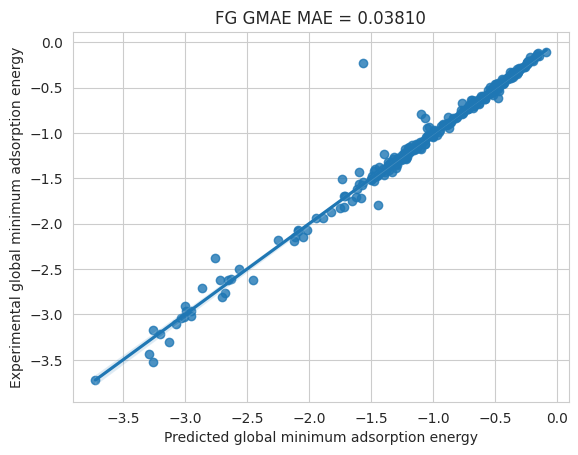

In [44]:
sns.regplot(x=predictions, y=labels)
plt.xlabel('Predicted global minimum adsorption energy')
plt.ylabel('Experimental global minimum adsorption energy')
plt.title(f'FG GMAE MAE = {test_MAE:.5f}')

### ocd_gmae (OCD GMAE dataset)

In [41]:
config['batch_size'] = 8
model = DGModel(config=config,
                  config_model=config['model']).to(config['device'])

number of parameters: 12.24M


In [42]:
name = 'ocd_gmae_processed.pt'
target = name.replace('_processed.pt', '')

datawrapper = CrystalDataLoader(
    root = config['root'],
    name = name,
    target = target,
    batch_size = config['batch_size'],
    num_workers = config['num_workers'],
    train_size = 0.8,
    valid_size = 0.1,
    test_size = 0.1,
    normalize = config['normalize'],
    idx_save_file = config['idx_save_file'],
    random_seed = config['random_seed']
)

_, _, test_loader = datawrapper.get_data_loaders()
print(test_loader)

Save ocd_gmae train_val_test idx !!!
Normalized ocd_gmae !!!


In [43]:
save_checkpoint = 'ocd_gmae_checkpoint_best.pt'

if config['ckpt_save_path']:
    # print('Loading pre-trained model from', config['load_pretrained_model_path'])
    ckpt_save_path = str(os.path.join(config['ckpt_save_path'], target))

    try:
        state_dict = torch.load(os.path.join(ckpt_save_path, str(save_checkpoint)),
                                map_location=config['device'])

        model.load_state_dict(state_dict, strict=True)
        print('Loading saved finetuned-model from', config['ckpt_save_path'], 'with success.')

    except FileNotFoundError:
        print("Saved finetuned-model weights not found. Predict from scratch.")

Loading saved finetuned-model from /home/zl/DGM/ckpt/finetuned with success.


In [98]:
(test_loss, test_MAE, test_R2_score, 
 test_RMSE, predictions, labels) = (
    pred_fn(test_loader, model, datawrapper, config['device'], criterion))

print('test loss is:', round(test_loss, 5))
print('test MAE is:', round(test_MAE, 5))
print('test R2_score is:', round(test_R2_score, 5))
print('test RMSE is:', round(test_RMSE, 5))

Testing...


100%|██████████| 12/12 [00:00<00:00, 19.47it/s]

test loss is: 0.06721
test MAE is: 0.32974
test R2_score is: 0.93786
test RMSE is: 0.55525


Text(0.5, 1.0, 'OCD GMAE MAE = 0.32974')

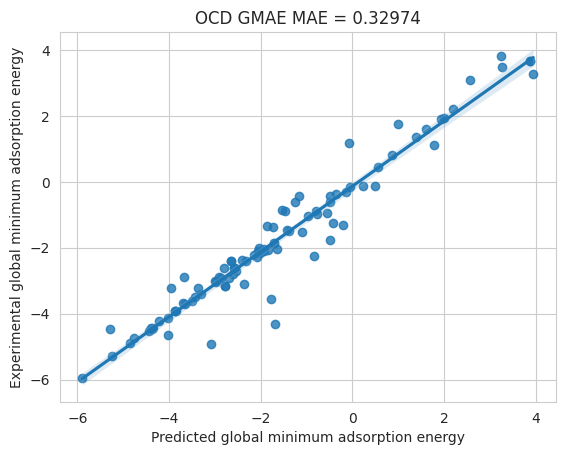

In [99]:
sns.regplot(x=predictions, y=labels)
plt.xlabel('Predicted global minimum adsorption energy')
plt.ylabel('Experimental global minimum adsorption energy')
plt.title(f'OCD GMAE MAE = {test_MAE:.5f}')

### Bandgap (HOIP dataset)

In [44]:
config['batch_size'] = 8
model = DGModel(config=config,
                  config_model=config['model']).to(config['device'])

number of parameters: 12.24M


In [46]:
name = 'HOIP_processed.pt'
target = 'Bandgap'

datawrapper = CrystalDataLoader(
    root = config['root'],
    name = name,
    target = target,
    batch_size = config['batch_size'],
    num_workers = config['num_workers'],
    train_size = 0.8,
    valid_size = 0.1,
    test_size = 0.1,
    normalize = config['normalize'],
    idx_save_file = config['idx_save_file'],
    random_seed = config['random_seed']
)

_, _, test_loader = datawrapper.get_data_loaders()
print(test_loader)

Save Bandgap train_val_test idx !!!
Normalized Bandgap !!!


In [47]:
save_checkpoint = 'Bandgap_checkpoint_best.pt'

if config['ckpt_save_path']:
    # print('Loading pre-trained model from', config['load_pretrained_model_path'])
    ckpt_save_path = str(os.path.join(config['ckpt_save_path'], target))

    try:
        state_dict = torch.load(os.path.join(ckpt_save_path, str(save_checkpoint)),
                                map_location=config['device'])

        model.load_state_dict(state_dict, strict=True)
        print('Loading saved finetuned-model from', config['ckpt_save_path'], 'with success.')

    except FileNotFoundError:
        print("Saved finetuned-model weights not found. Predict from scratch.")

Loading saved finetuned-model from /home/zl/DGM/ckpt/finetuned with success.


In [11]:
(test_loss, test_MAE, test_R2_score, 
 test_RMSE, predictions, labels) = (
    pred_fn(test_loader, model, datawrapper, config['device'], criterion))

print('test loss is:', round(test_loss, 5))
print('test MAE is:', round(test_MAE, 5))
print('test R2_score is:', round(test_R2_score, 5))
print('test RMSE is:', round(test_RMSE, 5))

Testing...


100%|██████████| 16/16 [00:01<00:00, 10.30it/s]

test loss is: 0.0194
test MAE is: 0.10347
test R2_score is: 0.98538
test RMSE is: 0.14912
